In [248]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [249]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [250]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [251]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


### Loss on dev set

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

NameError: name 'layers' is not defined

### NEW

In [75]:
# Linear Layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility


class Layer:
    def __init__(self,fan_in, fan_out, bias=False):
        self.w = torch.randn((fan_in, fan_out),generator = g) #/ (fan_in)**(0.5) # applying kaiming init
        self.bias = bias
        if bias:
            self.b = torch.zeros(fan_out)
            
    def __call__(self, x):
        y = x @ self.w
        self.out = y + self.b if self.bias else y
        return self.out
    

    def parameters(self):
        
        return [self.w] + [self.b] if self.bias else [self.w]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class BatchNormalization1:
    def __init__(self,nf, eps= 1e-5, mom=0.1):
        self.bngain = torch.ones(nf)
        self.bnbias = torch.zeros(nf)
        self.out = None
        self.mom = mom
        self.training = True
        self.running_mean = torch.ones(nf)
        self.running_var = torch.zeros(nf)
        self.eps = eps
    
    def __call__(self,x):
        
        if self.training:
            meani = x.mean(0, keepdim = True)
            vari = x.var(0, keepdim = True)
            
        else:
            meani = self.running_mean
            vari = self.running_var
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.mom)*self.running_mean + self.mom*meani
                self.running_var = (1-self.mom)*self.running_var + self.mom*vari

        self.out = self.bngain *((x - meani)/ torch.sqrt(vari + self.eps)) + self.bnbias

        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]

In [76]:
import torch.nn.functional as F


x = torch.randn(32, 30, generator = g)
y = torch.tensor([random.randint(0,26) for _ in range(32)] )

# Embedding layer,
n_embd = 10
n_vocab = 27
n_dim = 200
batch_size = 32
C = torch.randn((n_vocab,n_embd))
block_size = 3

st = [
    # x shape = 32, 30
    Layer(n_embd*block_size,n_dim), BatchNormalization1(n_dim), Tanh(), 
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_vocab),BatchNormalization1(n_vocab)
]


with torch.no_grad():
    st[-1].bngain *= 0.1
    
    for layer in st[:-1]:
        if isinstance(layer, Layer):
            layer.w *= 1



parameters = [C] + [p for l in st for p in l.parameters()]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters)) 

173724


In [77]:
y.shape

torch.Size([32])

In [78]:
lossi = []
        
for iteration in range(200000):
    
    # for iteration in range(2000):
    idx = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    x_emb = C[Xb].view(-1, block_size * n_embd)
    x = x_emb
    for idx,item in enumerate(st):
#         print(idx)
        x = item(x)

    loss = F.cross_entropy(x,Yb)
    
    for layer in st:
        layer.out.retain_grad() 
        
    for p in parameters:
        p.grad = None

    loss.backward()
    
    lr = 0.1 if iteration < 150000 else 0.01
    for p in parameters:

        p.data += -lr*p.grad
    
    if iteration % 10000 ==0:
        print(f'{iteration}/ 200000', loss.item())

    
    lossi.append(loss.item())
#     if iteration >= 10000:
#         break

0/ 200000 3.2973792552948
10000/ 200000 2.1864802837371826
20000/ 200000 2.300016403198242
30000/ 200000 1.9824109077453613
40000/ 200000 2.1860222816467285
50000/ 200000 1.8747204542160034
60000/ 200000 2.260319709777832
70000/ 200000 1.7065367698669434
80000/ 200000 2.3220694065093994
90000/ 200000 2.0555713176727295
100000/ 200000 2.5860719680786133
110000/ 200000 2.0385117530822754
120000/ 200000 2.1151678562164307
130000/ 200000 2.1560330390930176
140000/ 200000 2.6655075550079346
150000/ 200000 2.697312831878662
160000/ 200000 2.5881714820861816
170000/ 200000 1.780798077583313
180000/ 200000 1.9704279899597168
190000/ 200000 2.2696027755737305


In [80]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in st:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in st:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.077183246612549
val 2.1162490844726562


torch.Size([200])

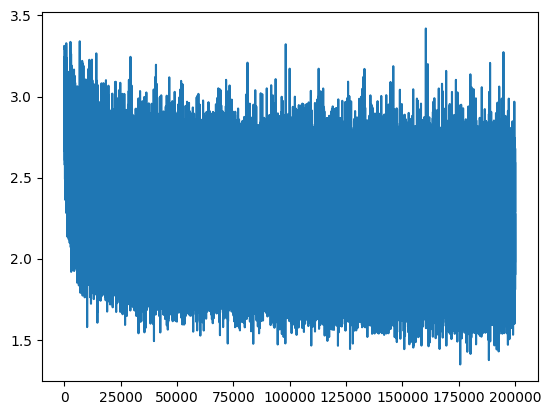

In [102]:
plt.plot(lossi)
plt.show()

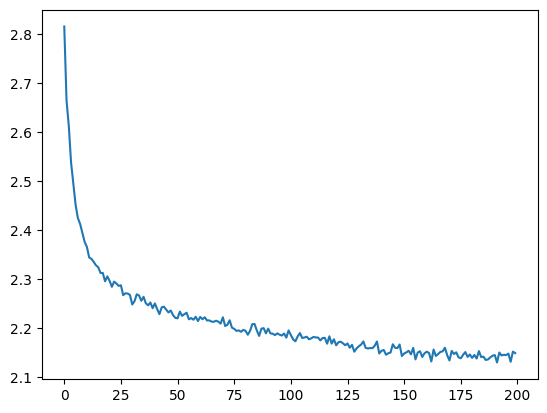

In [101]:

nli = torch.tensor(lossi).view(200,-1).mean(1)
nli.shape
plt.plot(nli)
plt.show()

### WaveNet

In [280]:
len(Xtr.shape)

2

In [281]:
# Linear Layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility


class Layer:
    def __init__(self,fan_in, fan_out, bias=False):
        self.w = torch.randn((fan_in, fan_out),generator = g) #/ (fan_in)**(0.5) # applying kaiming init
        self.bias = bias
        if bias:
            self.b = torch.zeros(fan_out)
            
    def __call__(self, x):
        y = x @ self.w
        self.out = y + self.b if self.bias else y
        return self.out
    

    def parameters(self):
        
        return [self.w] + [self.b] if self.bias else [self.w]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class BatchNormalization1:
    def __init__(self,nf, eps= 1e-5, mom=0.1):
        self.bngain = torch.ones(nf)
        self.bnbias = torch.zeros(nf)
        self.out = None
        self.mom = mom
        self.training = True
        self.running_mean = torch.ones(nf)
        self.running_var = torch.zeros(nf)
        self.eps = eps
    
    def __call__(self,x):
        
        if self.training:
            if len(x.shape) == 3:
                dim = (0,1)
            elif len(x.shape) ==2:
                dim = 0
            meani = x.mean(dim, keepdim = True)
            vari = x.var(dim, keepdim = True)
            
        else:
            meani = self.running_mean
            vari = self.running_var
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.mom)*self.running_mean + self.mom*meani
                self.running_var = (1-self.mom)*self.running_var + self.mom*vari

        self.out = self.bngain *((x - meani)/ torch.sqrt(vari + self.eps)) + self.bnbias

        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]
    
class EmbeddingLayer:
    def __init__(self, n_vocab, n_embed):
        self.C = torch.randn(n_vocab,n_embed)
        
    def __call__(self,x):
        out = self.C[x]
#         out = out.view(x.shape[0], -1)
        return out
    
    
    def parameters(self):
        return [self.C]
    

class Sequential:
    def __init__(self,layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x
    
    def parameters(self):
        return [p.parameters() for p in self.layers]
    
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
        
    def __call__(self,x):
        B,T,C = x.shape
        
        x = x.view(B, T//self.n, self.n*C)
        
        if x.shape[1] == 1:
            x = torch.squeeze(x, 1)
        self.out = x

        return self.out

In [282]:
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
        
    def __call__(self,x):
#         print(x.shape)
        B,T,C = x.shape
        
        x = x.view(B, T//self.n, self.n*C)
        
        if x.shape[1] == 1:
            x = torch.squeeze(x, 1)
        self.out = x

        return self.out
    
    def parameters(self):
        return []


In [283]:
import torch.nn.functional as F


x = torch.randn(32, 30, generator = g)
y = torch.tensor([random.randint(0,26) for _ in range(32)] )

# Embedding layer,
n_embd = 10
n_vocab = 27
n_dim = 200
batch_size = 32

block_size = 3


layers = [

    EmbeddingLayer(n_vocab,n_embd),
    FlattenConsecutive(2), Layer(2*n_embd,n_dim), BatchNormalization1(n_dim), Tanh(), 
    FlattenConsecutive(2), Layer(2*n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    FlattenConsecutive(2), Layer(2*n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_vocab),BatchNormalization1(n_vocab)
]


with torch.no_grad():
    layers[-1].bngain *= 0.1
    
    for layer in layers[:-1]:
        if isinstance(layer, Layer):
            layer.w *= 1

model = Sequential(layers)


parameters = [p for l in model.parameters() for p in l]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters)) 

170924


In [284]:
lossi = []
        
for iteration in range(200000):
    
    # for iteration in range(2000):
    idx = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    x = Xb
    
    logits = model(x)

    loss = F.cross_entropy(logits,Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if iteration < 150000 else 0.01
    
    for p in parameters:
        p.data += -lr*p.grad
    
    if iteration % 10000 ==0:
        print(f'{iteration}/ 200000', loss.item())

    
    lossi.append(loss.item())


0/ 200000 3.316556930541992
10000/ 200000 2.261958360671997
20000/ 200000 2.220181941986084
30000/ 200000 2.179208517074585
40000/ 200000 2.218005418777466
50000/ 200000 2.23244309425354
60000/ 200000 2.2925479412078857
70000/ 200000 2.5522890090942383
80000/ 200000 2.4725892543792725
90000/ 200000 2.2739946842193604
100000/ 200000 2.185131549835205
110000/ 200000 2.3486740589141846
120000/ 200000 2.1432933807373047
130000/ 200000 1.917876958847046
140000/ 200000 2.0588643550872803
150000/ 200000 2.2519259452819824
160000/ 200000 2.3521206378936768
170000/ 200000 2.418546199798584
180000/ 200000 2.228193521499634
190000/ 200000 2.394216775894165


In [286]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
#   for layer in st:
#     x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in st:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.03531551361084
val 2.0824830532073975
